In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings('ignore')

from PIL import Image 
import os 
import cv2 
from tqdm import tqdm 
import torch 
import torch.nn as nn 
import torch.optim as optim 
import torch.nn.functional as F 
pd.options.display.max_columns=50


In [2]:
train=pd.read_csv('./data/train_df.csv')
submission=pd.read_csv('./data/sample_submission.csv')
print(train)

                              image       nose_x      nose_y   left_eye_x  \
0      001-1-1-01-Z17_A-0000001.jpg  1046.389631  344.757881  1041.655294   
1      001-1-1-01-Z17_A-0000003.jpg  1069.850679  340.711494  1058.608552   
2      001-1-1-01-Z17_A-0000005.jpg  1084.475902  337.000008  1078.717997   
3      001-1-1-01-Z17_A-0000007.jpg  1042.320047  361.452689  1037.907194   
4      001-1-1-01-Z17_A-0000009.jpg  1058.046395  343.164191  1046.717997   
...                             ...          ...         ...          ...   
4190  642-2-4-31-Z148_E-0000023.jpg   637.251052  781.342260  1117.135818   
4191  642-2-4-31-Z148_E-0000025.jpg   637.251052  781.342260  1117.135818   
4192  642-2-4-31-Z148_E-0000027.jpg   637.251052  781.342260  1117.135818   
4193  642-2-4-31-Z148_E-0000029.jpg   637.251052  781.342260  1117.135818   
4194  642-2-4-31-Z148_E-0000031.jpg   637.251052  781.342260  1117.135818   

      left_eye_y  right_eye_x  right_eye_y   left_ear_x  left_ear_y  \
0   

In [3]:
import glob 
train_paths=glob.glob('./data/train_imgs/*.jpg')
test_paths=glob.glob('./data/test_imgs/*.jpg')
print(len(train_paths),len(test_paths))

4195 1600


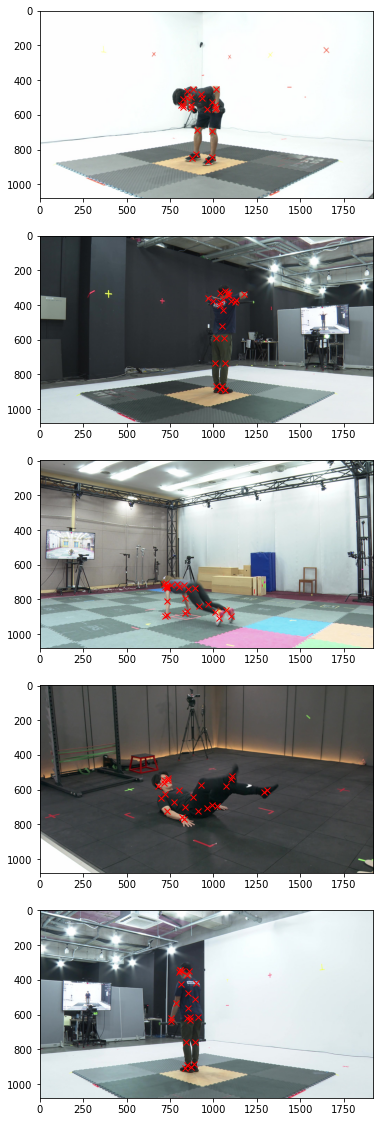

In [4]:
plt.figure(figsize=(40,20))
count=1

for i in np.random.randint(0,len(train_paths),5):
    plt.subplot(5,1,count)
    img_sample_path=train_paths[i]
    img=Image.open(img_sample_path)
    img_np=np.array(img)
    keypoint=train.iloc[:,1:49]
    keypoint_sample=keypoint.iloc[i,:]

    for j in range(0,len(keypoint.columns),2):
        plt.plot(keypoint_sample[j],keypoint_sample[j+1],'rx')
        plt.imshow(img_np)

    count+=1

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, concatenate, Input, Flatten, Dense
from tensorflow.keras import Model
train['path']=train_paths
def trainGenerator():
    for i in range(len(train)):
        img=tf.io.read_file(train['path'][i])# 경로를 통해서 이미지 읽기
        img=tf.image.decode_jpeg(img,channels=3)# 경로를 통해 불러오 이미지를 텐서로 변환 
        img=tf.image.resize(img,[180,320])# 이미지 리사이징 
        target=train.iloc[:,1:49].iloc[i,:]# keypoiny 뽑아주기 

        yield(img, target)
train_dataset = tf.data.Dataset.from_generator(trainGenerator, (tf.float32, tf.float32), (tf.TensorShape([180,320,3]),tf.TensorShape([48])))
train_dataset = train_dataset.batch(32).prefetch(1)

In [6]:
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.layers import Activation, Convolution2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, Conv2D,MaxPool2D, ZeroPadding2D,GlobalAveragePooling2D
from numpy.random import seed
model = Sequential()

model.add(Convolution2D(32, (3,3), padding='same', use_bias=False, input_shape=(180,320,3)))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(32, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.1))


model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.1))


model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.1))


model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(48))
model.compile(optimizer='adam', 
              loss='mean_squared_error',
              metrics=['mae'])


In [7]:
from keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from sklearn.model_selection import KFold,StratifiedKFold
# skf = StratifiedKFold(n_splits = 10, random_state = 2021, shuffle = True)
reLR = ReduceLROnPlateau(patience = 8,verbose = 1,factor = 0.5) 
es =EarlyStopping(monitor='loss', patience=8, mode='min')
mc = ModelCheckpoint('./data/best_model.h5', monitor='loss', mode='min', save_best_only=True)
model.fit(train_dataset,epochs=10,verbose=1,callbacks=[reLR,es,mc])

Epoch 1/10
132/132 [==============================] - 81s 575ms/step - loss: 78233.1703 - mae: 183.4406
Epoch 2/10
132/132 [==============================] - 76s 576ms/step - loss: 18355.4303 - mae: 102.8388
Epoch 3/10
132/132 [==============================] - 76s 576ms/step - loss: 20105.1393 - mae: 108.7620
Epoch 4/10
132/132 [==============================] - 76s 575ms/step - loss: 21794.0249 - mae: 109.3437
Epoch 5/10
132/132 [==============================] - 76s 578ms/step - loss: 16709.7188 - mae: 98.2303
Epoch 6/10
132/132 [==============================] - 77s 582ms/step - loss: 14337.1948 - mae: 90.6717
Epoch 7/10
132/132 [==============================] - 76s 573ms/step - loss: 14222.8779 - mae: 91.4723
Epoch 8/10
132/132 [==============================] - 76s 575ms/step - loss: 12233.2435 - mae: 83.9437
Epoch 9/10
132/132 [==============================] - 76s 576ms/step - loss: 12391.5410 - mae: 83.7083
Epoch 10/10
132/132 [==============================] - 76s 573ms/step

In [8]:
X_test=list()

for test_path in tqdm(test_paths):
    img=tf.io.read_file(test_path)
    img=tf.image.decode_jpeg(img,channels=3)
    img=tf.image.resize(img,[180,320])
    X_test.append(img)
    

100%|██████████| 1600/1600 [00:18<00:00, 87.79it/s]


In [9]:
X_test=tf.stack(X_test,axis=0)
X_test.shape

TensorShape([1600, 180, 320, 3])

In [10]:
pred=model.predict(X_test)

In [11]:
submission.iloc[:,1:]=pred
submission

,image,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,right_ear_y,left_shoulder_x,left_shoulder_y,right_shoulder_x,right_shoulder_y,left_elbow_x,left_elbow_y,right_elbow_x,right_elbow_y,left_wrist_x,left_wrist_y,right_wrist_x,right_wrist_y,left_hip_x,left_hip_y,right_hip_x,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y,neck_x,neck_y,left_palm_x,left_palm_y,right_palm_x,right_palm_y,spine2(back)_x,spine2(back)_y,spine1(waist)_x,spine1(waist)_y,left_instep_x,left_instep_y,right_instep_x,right_instep_y
0,649-2-4-32-Z148_A-0000001.jpg,1259.928467,467.473785,1189.743774,486.674103,1247.942627,468.672211,1182.024292,530.029053,1242.754272,501.690277,1091.515991,577.755615,1202.783447,561.909241,963.690002,449.154633,1167.420898,390.261902,949.120789,361.137482,1284.924561,425.365631,1020.009521,562.736755,1045.290405,507.618744,863.455566,485.189392,980.714905,503.798981,781.427246,689.593811,928.776733,675.846375,1110.223389,601.736328,962.410950,432.131378,1228.292480,400.553741,1084.267944,576.546265,1006.894592,579.697388,793.336182,695.290405,955.529358,655.566895
1,649-2-4-32-Z148_A-0000003.jpg,1257.042480,467.944702,1187.189941,486.386719,1245.542480,468.614471,1179.356201,529.780823,1240.619751,501.831848,1088.978882,576.978516,1200.470581,561.591431,961.697815,449.072052,1165.344360,389.858948,947.532593,360.498810,1282.743530,424.825256,1017.426208,561.210632,1042.819458,506.245575,860.854187,483.424011,978.226929,501.539215,779.755310,688.598206,926.707886,674.507324,1108.243530,601.710876,960.216736,432.431458,1226.263794,399.893219,1082.155884,576.337769,1004.727783,578.769714,791.438599,694.907959,953.691040,655.309509
2,649-2-4-32-Z148_A-0000005.jpg,1270.019287,481.321838,1196.597534,501.553894,1262.605225,480.243042,1196.011597,538.209534,1251.629883,511.161652,1093.532959,583.056091,1214.621094,571.061035,967.476074,449.060547,1181.975464,391.404358,960.523315,362.861908,1303.086792,435.315613,1024.879028,560.382812,1057.435791,500.305328,864.804688,481.744263,989.387756,501.610474,788.301331,686.430969,939.031250,670.759155,1119.513428,612.714294,971.069519,438.905548,1242.675781,409.929016,1092.278442,581.568848,1011.154663,580.970093,795.186462,689.362366,970.198181,655.315063
3,649-2-4-32-Z148_A-0000007.jpg,1295.979858,527.223267,1216.669067,553.482300,1277.822998,536.423889,1213.633423,584.557861,1258.904541,562.221985,1100.207642,616.544434,1220.168701,613.758667,995.154297,485.052460,1190.691406,425.180023,1007.252930,396.964508,1310.285522,473.974884,1023.564941,575.553284,1056.474976,518.680664,854.423035,498.333008,977.988220,511.496674,778.984741,706.551208,925.493408,680.959229,1146.661133,647.917175,1006.499329,495.500916,1258.026978,446.002686,1113.645264,611.294983,1022.980225,605.789429,789.809937,711.542175,963.934082,673.186890
4,649-2-4-32-Z148_A-0000009.jpg,1255.013916,511.874298,1186.679810,524.235291,1255.417969,498.367462,1193.125488,551.696289,1236.466919,524.239319,1078.054565,585.432800,1200.168701,583.717102,963.060791,448.436798,1168.228149,393.702911,969.993652,374.093323,1294.502563,458.071259,1014.217041,548.010742,1044.372314,491.099396,846.160950,470.703003,974.208252,487.307037,781.273743,666.179871,926.421387,650.558105,1107.125732,629.381042,963.674805,459.941864,1228.563843,429.082581,1078.209839,591.847229,993.993652,581.843994,773.263977,667.738770,952.946838,643.426819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,786-3-5-41-Z94_E-0000023.jpg,898.518311,430.193542,844.343140,553.565979,877.674500,483.019409,891.995544,544.846680,927.437866,531.572144,806.282532,557.762573,1024.238770,552.772644,830.755859,541.923828,1009.668152,536.200012,878.970093,534.356201,1004.195557,566.359619,873.749878,702.750854,95

In [12]:
submission.to_csv('baseline_submission.csv',index=False)